In [2]:
!pip install holoviews

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 4.3 MB 27.4 MB/s            
     |████████████████████████████████| 85 kB 8.9 MB/s             
     |████████████████████████████████| 40 kB 10.5 MB/s            
     |████████████████████████████████| 12.9 MB 38.3 MB/s            
     |████████████████████████████████| 1.6 MB 61.3 MB/s            
     |████████████████████████████████| 12.9 MB 70.0 MB/s            
     |████████████████████████████████| 12.8 MB 49.7 MB/s            
     |████████████████████████████████| 12.8 MB 59.6 MB/s            
     |████████████████████████████████| 12.8 MB 44.3 MB/s            
     |████████████████████████████████| 10.7 MB 65.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 97 kB 15.5 MB/s            
  Created wheel for bokeh: filename=bokeh-2.3.3-py3-none-any.whl size=11342785 sha256=dabffbfae0a87598adb9c3789a1

In [1]:
## Importing all necessary Libs that will be required
%matplotlib inline
import pandas as pd
import numpy as np
import os
import warnings
import pickle
import matplotlib
import matplotlib.pyplot as plt
import boto3
# import sagemaker
import sys
import seaborn as sns
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

ModuleNotFoundError: No module named 'holoviews'

In [18]:
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('white')
sns.set_palette('pastel',8)
seed=345
np.random.seed(seed)

In [177]:
## Loading Data
df = pd.read_csv("ambient_temperature_system_failure.csv")
print("")
# print("Data columns ---> {}".format(list(fulldata.columns)))
# fulldata = df
print("Total Number of records ---> {}".format(df.shape[0]))
print("Total Number of features ---> {}".format(df.shape[1]))
print("")
df.head()


Total Number of records ---> 7267
Total Number of features ---> 2



,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [141]:
anomaly_points = [
        ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],
        ["2013-12-15 17:50:00.000000","2013-12-17 17:00:00.000000"],
        ["2014-01-27 14:20:00.000000","2014-01-29 13:30:00.000000"],
        ["2014-02-07 14:55:00.000000","2014-02-09 14:05:00.000000"]
]
df['timestamp'] = pd.to_datetime(df['timestamp'])
#is anomaly? : True => 1, False => 0
df['anomaly'] = 0
for start, end in anomaly_points:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)

In [21]:
type(anomaly_points)

list

In [142]:
df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head(3)

,value,anomaly,year,month,day,hour,minute
timestamp,,,,,,,
2013-07-04 00:00:00,69.880835,0,2013,7,4,0,0
2013-07-04 01:00:00,71.220227,0,2013,7,4,1,0
2013-07-04 02:00:00,70.877805,0,2013,7,4,2,0


In [23]:
anomalies = [[ind, value] for ind, value in zip(df[df['anomaly']==1].index, df.loc[df['anomaly']==1,'value'])]
(hv.Curve(df['value'], label="Temperature") * hv.Points(anomalies, label="Anomaly Points").opts(color='red', legend_position='bottom', size=2, title="Temperature & Given Anomaly Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature     :Curve   [timestamp]   (value)
   .Points.Anomaly_Points :Points   [x,y]

In [143]:
from sagemaker import RandomCutForest
import boto3
import botocore
import sagemaker
import sys

In [144]:
bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-temperature"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [145]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::241082659383:role/service-role/AmazonSageMaker-ExecutionRole-20200525T172601


In [146]:
# Training
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_sample_per_tree=512,
    num_trees=50
)
# automatically upload the training data to s3 and run the training job
rcf.fit(rcf.record_set(df.value.to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-11-25 07:52:42 Starting - Starting the training job...
2021-11-25 07:53:11 Starting - Launching requested ML instancesProfilerReport-1637826762: InProgress
......
2021-11-25 07:54:12 Starting - Preparing the instances for training............
2021-11-25 07:56:12 Downloading - Downloading input data...
2021-11-25 07:56:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/25/2021 07:56:48 INFO 140423822903104] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[11/25/2021 07:56:48 INFO 1404238229


2021-11-25 07:57:12 Uploading - Uploading generated training model
2021-11-25 07:57:12 Completed - Training job completed
Training seconds: 69
Billable seconds: 69


### 用原始資料train

In [178]:
data = pd.read_csv("ambient_temperature_system_failure.csv")
data.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [179]:
# Training
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_sample_per_tree=512,
    num_trees=50
)
# automatically upload the training data to s3 and run the training job
rcf.fit(rcf.record_set(data.value.to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-11-25 08:23:59 Starting - Starting the training job...
2021-11-25 08:24:24 Starting - Launching requested ML instancesProfilerReport-1637828638: InProgress
......
2021-11-25 08:25:24 Starting - Preparing the instances for training.........
2021-11-25 08:26:54 Downloading - Downloading input data...
2021-11-25 08:27:24 Training - Downloading the training image...
2021-11-25 08:27:58 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[11/25/2021 08:27:51 INFO 139667720070976] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 89


2021-11-25 08:28:25 Completed - Training job completed
ProfilerReport-1637828638: NoIssuesFound
Training seconds: 72
Billable seconds: 72


In [180]:
rcf_interference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------!

In [153]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
rcf_interference.serializer = CSVSerializer()
rcf_interference.deserializer = JSONDeserializer()
machine_data_numpy = df.value.to_numpy().reshape(-1, 1)

results = rcf_interference.predict(
    machine_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

results = rcf_interference.predict(machine_data_numpy)
scores = [datum["score"] for datum in results["scores"]]
# add scores to taxi data frame and print first few values
df["score"] = pd.Series(scores, index=df.index)
df.head()

,value,anomaly,year,month,day,hour,minute,score
timestamp,,,,,,,,
2013-07-04 00:00:00,69.880835,0,2013,7,4,0,0,1.904150
2013-07-04 01:00:00,71.220227,0,2013,7,4,1,0,1.608249
2013-07-04 02:00:00,70.877805,0,2013,7,4,2,0,1.692195
2013-07-04 03:00:00,68.959400,0,2013,7,4,3,0,2.156764
2013-07-04 04:00:00,69.283551,0,2013,7,4,4,0,2.027279


### 用原始資料predict

In [181]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
rcf_interference.serializer = CSVSerializer()
rcf_interference.deserializer = JSONDeserializer()
machine_data_numpy = data.value.to_numpy().reshape(-1, 1)

results = rcf_interference.predict(
    machine_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

results = rcf_interference.predict(machine_data_numpy)
scores = [datum["score"] for datum in results["scores"]]
# add scores to taxi data frame and print first few values
data["score"] = pd.Series(scores, index=data.index)
data.head()

,timestamp,value,score
0,2013-07-04 00:00:00,69.880835,1.916953
1,2013-07-04 01:00:00,71.220227,1.739741
2,2013-07-04 02:00:00,70.877805,1.723972
3,2013-07-04 03:00:00,68.959400,2.121162
4,2013-07-04 04:00:00,69.283551,2.065825


In [189]:
len(data)

7267

<AxesSubplot:>

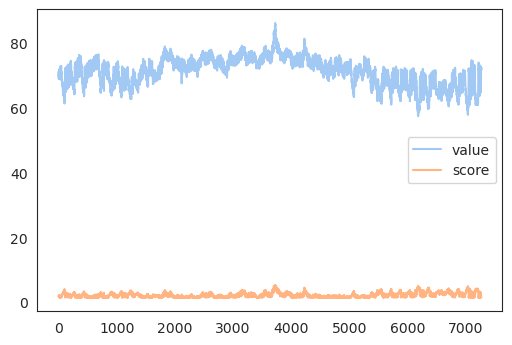

In [197]:
matplotlib.rcParams["figure.dpi"] = 100
data.plot()

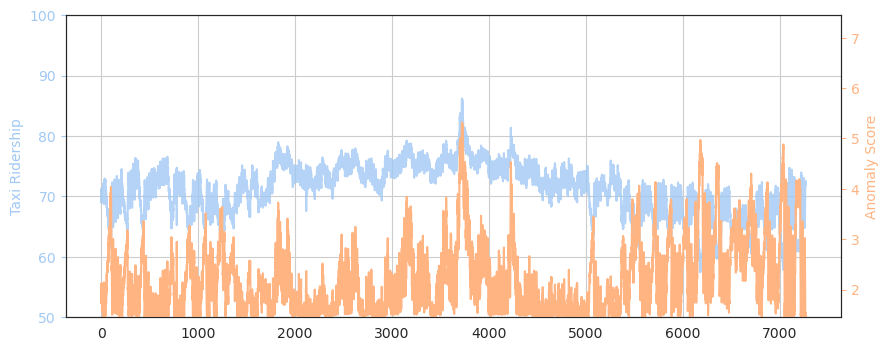

In [204]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(data)
# start, end = 5500, 6500
taxi_data_subset = data[start:end]

ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(50, 100)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

In [200]:
taxi_data_subset.head()

,timestamp,value,score
0,2013-07-04 00:00:00,69.880835,1.916953
1,2013-07-04 01:00:00,71.220227,1.739741
2,2013-07-04 02:00:00,70.877805,1.723972
3,2013-07-04 03:00:00,68.959400,2.121162
4,2013-07-04 04:00:00,69.283551,2.065825


### 計算anomalies

In [190]:
score_mean = data["score"].mean()
score_std = data["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
anomalies

,timestamp,value,score
3695,2013-12-21 18:00:00,80.520263,4.302254
3697,2013-12-21 20:00:00,82.289240,4.744353
3698,2013-12-21 21:00:00,82.989869,4.875773
3699,2013-12-21 22:00:00,83.247886,4.923849
3700,2013-12-21 23:00:00,82.519659,4.789155
3701,2013-12-22 00:00:00,82.736802,4.832633
3702,2013-12-22 01:00:00,83.780995,5.004434
3703,2013-12-22 02:00:00,83.008634,4.879056
3704,2013-12-22 03:00:00,82.815627,4.847075
3705,2013-12-22 04:00:00,81.774744,4.631440


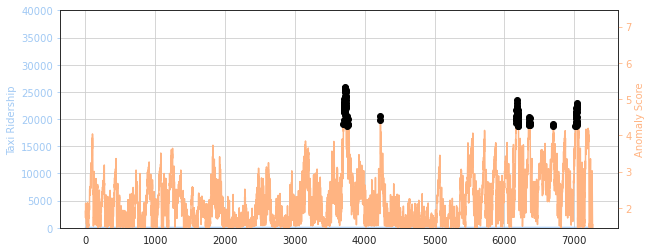

In [191]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

### 原始資料anomalies

In [185]:
score_mean = data["score"].mean()
score_std = data["score"].std()
score_cutoff = score_mean + 3 * score_std

#anomalies_cutoff = data[data["score"] > score_cutoff]
#anomalies_cutoff
anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

TypeError: '>' not supported between instances of 'list' and 'float'

In [125]:
anomalies_list = anomalies_cutoff['timestamp'].tolist()
anomalies_list

['2013-07-07 22:00:00',
 '2013-07-08 00:00:00',
 '2013-07-08 01:00:00',
 '2013-07-08 03:00:00',
 '2013-07-08 05:00:00',
 '2013-07-08 06:00:00',
 '2013-07-08 07:00:00',
 '2013-10-01 23:00:00',
 '2013-10-02 01:00:00',
 '2013-10-02 02:00:00',
 '2013-11-29 00:00:00',
 '2013-11-29 03:00:00',
 '2013-11-29 04:00:00',
 '2013-11-29 05:00:00',
 '2013-11-29 06:00:00',
 '2013-11-29 10:00:00',
 '2013-11-30 02:00:00',
 '2013-11-30 03:00:00',
 '2013-11-30 17:00:00',
 '2013-11-30 19:00:00',
 '2013-11-30 22:00:00',
 '2013-12-01 00:00:00',
 '2013-12-14 21:00:00',
 '2013-12-15 00:00:00',
 '2013-12-15 02:00:00',
 '2013-12-15 23:00:00',
 '2013-12-16 00:00:00',
 '2013-12-16 01:00:00',
 '2013-12-16 02:00:00',
 '2013-12-16 04:00:00',
 '2013-12-20 23:00:00',
 '2013-12-21 00:00:00',
 '2013-12-21 01:00:00',
 '2013-12-21 02:00:00',
 '2013-12-21 03:00:00',
 '2013-12-21 08:00:00',
 '2013-12-21 12:00:00',
 '2013-12-21 14:00:00',
 '2013-12-21 17:00:00',
 '2013-12-21 18:00:00',
 '2013-12-21 19:00:00',
 '2013-12-21 20:

### 三倍標準差

In [166]:
anomalies_point = [
        ['2013-12-21 18:00:00',"2013-12-21 23:00:00"],
        ["2013-12-22 00:00:00","2013-12-22 23:00:00"],
        ["2013-12-23 00:00:00","2013-12-23 13:00:00"],
        ['2013-12-23 16:00:00','2013-12-23 16:00:00'],
        ['2013-12-23 23:00:00','2013-12-23 23:00:00'],
        ["2013-12-24 00:00:00","2013-12-24 03:00:00"],
        ['2013-12-24 05:00:00','2013-12-24 06:00:00'],
        ['2013-12-24 09:00:00','2013-12-24 09:00:00'],
        ['2014-01-12 20:00:00','2014-01-12 21:00:00'],
        ['2014-04-12 20:00:00','2014-04-12 23:00:00'],
        ['2014-04-13 00:00:00','2014-04-13 23:00:00'],
        ['2014-04-14 00:00:00','2014-04-14 07:00:00'],
        ['2014-04-20 09:00:00','2014-04-20 20:00:00'],
        ['2014-04-21 00:00:00','2014-04-21 04:00:00'],
        ['2014-05-05 05:00:00','2014-05-05 05:00:00'],
        ['2014-05-18 09:00:00','2014-05-18 23:00:00'],
        ['2014-05-19 00:00:00','2014-05-19 08:00:00']
]

In [127]:
anomalies_point = [
        ['2013-12-21 18:00:00',"2013-12-21 23:00:00"],
        ["2013-12-22 00:00:00","2013-12-22 23:00:00"],
        ["2013-12-23 00:00:00","2013-12-23 13:00:00"],
        ['2013-12-23 16:00:00','2013-12-23 16:00:00'],
        ['2013-12-23 23:00:00','2013-12-23 23:00:00'],
        ["2013-12-24 00:00:00","2013-12-24 03:00:00"],
        ['2013-12-24 05:00:00','2013-12-24 06:00:00'],
        ['2013-12-24 09:00:00','2013-12-24 09:00:00'],
        ['2014-01-12 20:00:00','2014-01-12 22:00:00'],
        ['2014-04-13 00:00:00','2014-04-13 23:00:00'],
        ['2014-04-14 00:00:00','2014-04-14 07:00:00'],
        ['2014-04-20 09:00:00','2014-04-20 20:00:00'],
        ['2014-04-21 00:00:00','2014-04-21 04:00:00'],
        ['2014-05-05 04:00:00','2014-05-05 05:00:00'],
        ['2014-05-18 08:00:00','2014-05-18 23:00:00'],
        ['2014-05-19 00:00:00','2014-05-19 08:00:00']
]

In [98]:
anomalies_list

['2013-12-21 18:00:00',
 '2013-12-21 20:00:00',
 '2013-12-21 21:00:00',
 '2013-12-21 22:00:00',
 '2013-12-21 23:00:00',
 '2013-12-22 00:00:00',
 '2013-12-22 01:00:00',
 '2013-12-22 02:00:00',
 '2013-12-22 03:00:00',
 '2013-12-22 04:00:00',
 '2013-12-22 05:00:00',
 '2013-12-22 06:00:00',
 '2013-12-22 07:00:00',
 '2013-12-22 08:00:00',
 '2013-12-22 09:00:00',
 '2013-12-22 10:00:00',
 '2013-12-22 11:00:00',
 '2013-12-22 13:00:00',
 '2013-12-22 14:00:00',
 '2013-12-22 15:00:00',
 '2013-12-22 16:00:00',
 '2013-12-22 17:00:00',
 '2013-12-22 18:00:00',
 '2013-12-22 19:00:00',
 '2013-12-22 20:00:00',
 '2013-12-22 21:00:00',
 '2013-12-22 22:00:00',
 '2013-12-22 23:00:00',
 '2013-12-23 00:00:00',
 '2013-12-23 01:00:00',
 '2013-12-23 02:00:00',
 '2013-12-23 03:00:00',
 '2013-12-23 04:00:00',
 '2013-12-23 05:00:00',
 '2013-12-23 06:00:00',
 '2013-12-23 07:00:00',
 '2013-12-23 08:00:00',
 '2013-12-23 09:00:00',
 '2013-12-23 10:00:00',
 '2013-12-23 12:00:00',
 '2013-12-23 13:00:00',
 '2013-12-23 16:

In [128]:
## Loading Data
df = pd.read_csv("ambient_temperature_system_failure.csv")
print("")
# print("Data columns ---> {}".format(list(fulldata.columns)))
# fulldata = df
print("Total Number of records ---> {}".format(df.shape[0]))
print("Total Number of features ---> {}".format(df.shape[1]))
print("")
df.head()


Total Number of records ---> 7267
Total Number of features ---> 2



,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [169]:
df.head()

,value,anomaly,year,month,day,hour,minute,score
timestamp,,,,,,,,
2013-07-04 00:00:00,69.880835,0,2013,7,4,0,0,1.904150
2013-07-04 01:00:00,71.220227,0,2013,7,4,1,0,1.608249
2013-07-04 02:00:00,70.877805,0,2013,7,4,2,0,1.692195
2013-07-04 03:00:00,68.959400,0,2013,7,4,3,0,2.156764
2013-07-04 04:00:00,69.283551,0,2013,7,4,4,0,2.027279


In [171]:
df['timestamp']

KeyError: 'timestamp'

In [172]:
for start, end in anomalies_point:
    df.loc[((df.index >= start) & (df.index <= end)), 'anomaly'] = 1

In [175]:
df[df['anomaly'] == 1]

,value,anomaly,year,month,day,hour,minute,score
timestamp,,,,,,,,
2013-12-10 07:00:00,72.630171,1,2013,12,10,7,0,1.525903
2013-12-10 08:00:00,72.716138,1,2013,12,10,8,0,1.472765
2013-12-10 09:00:00,72.717225,1,2013,12,10,9,0,1.472409
2013-12-10 10:00:00,73.733041,1,2013,12,10,10,0,1.576415
2013-12-10 11:00:00,72.677123,1,2013,12,10,11,0,1.486751
2013-12-10 12:00:00,73.645475,1,2013,12,10,12,0,1.612289
2013-12-10 13:00:00,72.306998,1,2013,12,10,13,0,1.530405
2013-12-10 14:00:00,72.643278,1,2013,12,10,14,0,1.520904
2013-12-10 15:00:00,72.706500,1,2013,12,10,15,0,1.476425


In [167]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
#is anomaly? : True => 1, False => 0
df['anomaly'] = 0
for start, end in anomalies_point:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)

KeyError: 'timestamp'

In [176]:
anomalies = [[ind, value] for ind, value in zip(df[df['anomaly']==1].index, df.loc[df['anomaly']==1,'value'])]
(hv.Curve(df['value'], label="Temperature") * hv.Points(anomalies, label="Anomaly Points").opts(color='red', legend_position='bottom', size=2, title="Temperature & Given Anomaly Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature     :Curve   [timestamp]   (value)
   .Points.Anomaly_Points :Points   [x,y]

In [133]:
taxi_data = df

In [135]:
taxi_data.head()

,value,anomaly,year,month,day,hour,minute
timestamp,,,,,,,
2013-07-04 00:00:00,69.880835,0,2013,7,4,0,0
2013-07-04 01:00:00,71.220227,0,2013,7,4,1,0
2013-07-04 02:00:00,70.877805,0,2013,7,4,2,0
2013-07-04 03:00:00,68.959400,0,2013,7,4,3,0
2013-07-04 04:00:00,69.283551,0,2013,7,4,4,0


KeyError: 'score'

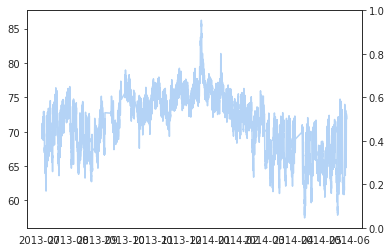

In [ ]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

In [35]:
sagemaker.Session().delete_endpoint(rcf_interference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
